In [1]:
%load_ext jupyter_black
import torch
import torch.optim as optim
import torch.nn as nn
from optimizers.lsgd import LSGD
from optimizers.lrmsprop import LRMSprop
from optimizers.ladam import LAdam
from optimizers.ladadelta import LAdadelta
from optimizers.lsgd import APLSGD
import matplotlib.pyplot as plt
import numpy as np
import scienceplots
import tqdm
import math
from training.train import train, plot_langevin_loss
from diffusion.deephedging import DeepHedging
from scheduler import PiecewiseConstantScheduler

plt.style.use(["science", "no-latex", "grid"])

seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
train_batch = 512
test_batch = 512
train_size = 5
test_size = 25

### Single control:

In [3]:
def test_diag_single_ctrl(
    model_config,
    N_euler,
    control_config,
    optim,
    langevin_optim,
    name,
    lr,
    target_lr,
    sigma,
    epochs,
    total_iters,
    **optim_kwargs,
):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

    for i, N in enumerate(N_euler):
        # Vanilla algo
        ocp = DeepHedging(**model_config, N_euler=N)
        ocp.set_control(control_config, multiple_controls=False)
        optim_w = torch.optim.SGD(ocp.w.parameters(), lr=2e-3, momentum=0.9)
        vanilla_optim = optim(ocp.control.parameters(), lr=lr, **optim_kwargs)
        scheduler = PiecewiseConstantScheduler(
            vanilla_optim, target_lr=target_lr, target_sigma=0, total_iters=total_iters
        )
        scheduler_w = PiecewiseConstantScheduler(
            optim_w, target_lr=target_lr, target_sigma=0, total_iters=total_iters
        )
        train_loss, test_loss, test_ci = train(
            ocp,
            [vanilla_optim, optim_w],
            [scheduler, scheduler_w],
            name,
            epochs,
            train_size,
            test_size,
            train_batch,
            test_batch,
        )
        axs[i].plot(
            np.arange(len(test_loss)),
            test_loss,
            marker="o",
            mec="k",
            ms=3,
            label=name,
        )
        axs[i].fill_between(
            np.arange(len(test_loss)),
            np.array(test_loss) - np.array(test_ci),
            np.array(test_loss) + np.array(test_ci),
            alpha=0.2,
        )

        # Langevin algo
        ocp = DeepHedging(**model_config, N_euler=N)
        ocp.set_control(control_config, multiple_controls=False)
        optim_w = torch.optim.SGD(ocp.w.parameters(), lr=2e-3, momentum=0.9)
        loptim = langevin_optim(ocp.control.parameters(), lr=lr, sigma=sigma[i])
        scheduler = PiecewiseConstantScheduler(
            loptim, target_lr=target_lr, target_sigma=0, total_iters=total_iters
        )
        scheduler_w = PiecewiseConstantScheduler(
            optim_w, target_lr=target_lr, target_sigma=0, total_iters=total_iters
        )
        train_loss, test_loss, test_ci = train(
            ocp,
            [loptim, optim_w],
            [scheduler, scheduler_w],
            f"L-{name}",
            epochs,
            train_size,
            test_size,
            train_batch,
            test_batch,
        )
        axs[i].plot(
            np.arange(len(test_loss)),
            test_loss,
            marker="o",
            mec="k",
            ms=3,
            label=f"L-{name}",
        )
        axs[i].fill_between(
            np.arange(len(test_loss)),
            np.array(test_loss) - np.array(test_ci),
            np.array(test_loss) + np.array(test_ci),
            alpha=0.2,
        )

        if i == 0:
            axs[i].set_ylabel(r"$J(u_\theta)$")
        axs[i].set_xlabel("Epochs")
        if i == 2:
            legend = axs[i].legend(fancybox=True, edgecolor="k", loc=0)
            legend.get_frame().set_linewidth(0.5)

        axs[i].set_ylim((0, 1.2))

    plt.show()
    plt.close()

    return fig

In [4]:
alpha = 0.9
ell = lambda x: nn.functional.relu(x) / (1.0 - alpha)
dim = 5
s0 = 1.0
v0 = 0.1


model_config = dict(
    T=1.0,
    dim=dim,
    ell=ell,
    a=torch.ones(dim),
    b=0.04 * torch.ones(dim),
    sigma=2.0 * torch.ones(dim),
    rho=-0.7 * torch.ones(dim),
    K=s0 * torch.ones(dim),
    T_COST=5e-4,
    S_0=s0 * torch.ones(dim),
    V_0=v0 * torch.ones(dim),
)

control_config = dict(
    input_dim=1 + 4 * dim,
    output_dim=2 * dim,
    hidden_dim=32,
    depth=2,
    activation=nn.ReLU(),
    out_transform=nn.ReLU(),
)

Deep hedging: Epoch 99, Adam, lr=0.000, sigma=0.000, train=0.145, test=0.139: 100%|██████████| 100/100 [00:27<00:00,  3.61it/s]
Deep hedging: Epoch 99, L-Adam, lr=0.000, sigma=0.000, train=0.358, test=0.342: 100%|██████████| 100/100 [00:27<00:00,  3.63it/s]
Deep hedging: Epoch 99, Adam, lr=0.000, sigma=0.000, train=0.303, test=0.307: 100%|██████████| 100/100 [00:45<00:00,  2.18it/s]
Deep hedging: Epoch 99, L-Adam, lr=0.000, sigma=0.000, train=0.196, test=0.173: 100%|██████████| 100/100 [00:46<00:00,  2.17it/s]
Deep hedging: Epoch 99, Adam, lr=0.000, sigma=0.000, train=0.379, test=0.398: 100%|██████████| 100/100 [01:33<00:00,  1.07it/s]
Deep hedging: Epoch 99, L-Adam, lr=0.000, sigma=0.000, train=0.330, test=0.333: 100%|██████████| 100/100 [01:33<00:00,  1.07it/s]


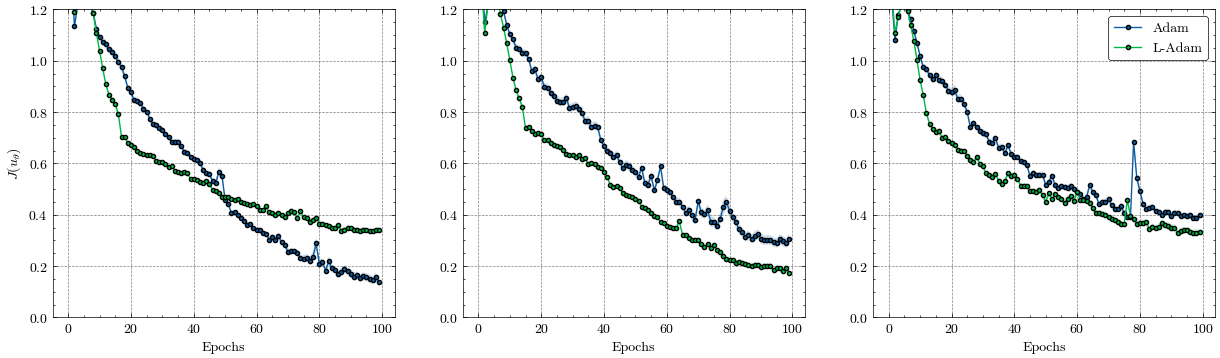

In [5]:
adam_single_ctrl = test_diag_single_ctrl(
    model_config,
    [30, 50, 100],
    control_config,
    torch.optim.Adam,
    LAdam,
    "Adam",
    2e-3,
    2e-4,
    [2e-4, 2e-4, 2e-4],
    100,
    80,
)

Deep hedging: Epoch 99, Adadelta, lr=0.050, sigma=0.000, train=0.410, test=0.414: 100%|██████████| 100/100 [00:29<00:00,  3.38it/s]
Deep hedging: Epoch 99, L-Adadelta, lr=0.050, sigma=0.000, train=0.240, test=0.234: 100%|██████████| 100/100 [00:33<00:00,  2.98it/s]
Deep hedging: Epoch 99, Adadelta, lr=0.050, sigma=0.000, train=0.555, test=0.534: 100%|██████████| 100/100 [00:53<00:00,  1.86it/s]
Deep hedging: Epoch 99, L-Adadelta, lr=0.050, sigma=0.000, train=0.176, test=0.152: 100%|██████████| 100/100 [00:52<00:00,  1.91it/s]
Deep hedging: Epoch 99, Adadelta, lr=0.050, sigma=0.000, train=0.371, test=0.400: 100%|██████████| 100/100 [01:36<00:00,  1.03it/s]
Deep hedging: Epoch 99, L-Adadelta, lr=0.050, sigma=0.000, train=0.219, test=0.209: 100%|██████████| 100/100 [01:57<00:00,  1.18s/it]


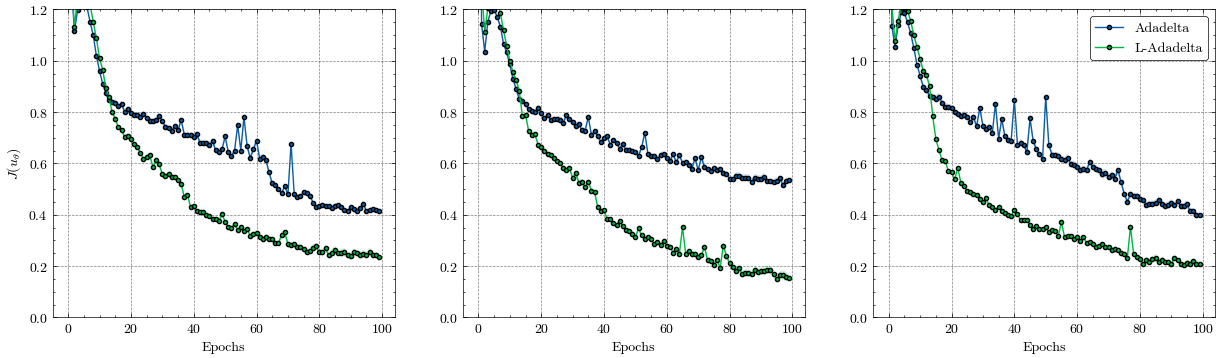

In [6]:
adadelta_single_ctrl = test_diag_single_ctrl(
    model_config,
    [30, 50, 100],
    control_config,
    torch.optim.Adadelta,
    LAdadelta,
    "Adadelta",
    5e-1,
    5e-2,
    [5e-3, 5e-3, 5e-3],
    100,
    80,
    rho=0.95,
)

Deep hedging: Epoch 99, RMSprop, lr=0.000, sigma=0.000, train=0.215, test=0.203: 100%|██████████| 100/100 [00:33<00:00,  3.01it/s]
Deep hedging: Epoch 99, L-RMSprop, lr=0.000, sigma=0.000, train=0.283, test=0.268: 100%|██████████| 100/100 [00:31<00:00,  3.20it/s]
Deep hedging: Epoch 99, RMSprop, lr=0.000, sigma=0.000, train=0.312, test=0.311: 100%|██████████| 100/100 [00:51<00:00,  1.95it/s]
Deep hedging: Epoch 99, L-RMSprop, lr=0.000, sigma=0.000, train=0.183, test=0.153: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s]
Deep hedging: Epoch 99, RMSprop, lr=0.000, sigma=0.000, train=0.323, test=0.317: 100%|██████████| 100/100 [01:45<00:00,  1.05s/it]
Deep hedging: Epoch 99, L-RMSprop, lr=0.000, sigma=0.000, train=0.476, test=0.477: 100%|██████████| 100/100 [01:55<00:00,  1.15s/it]


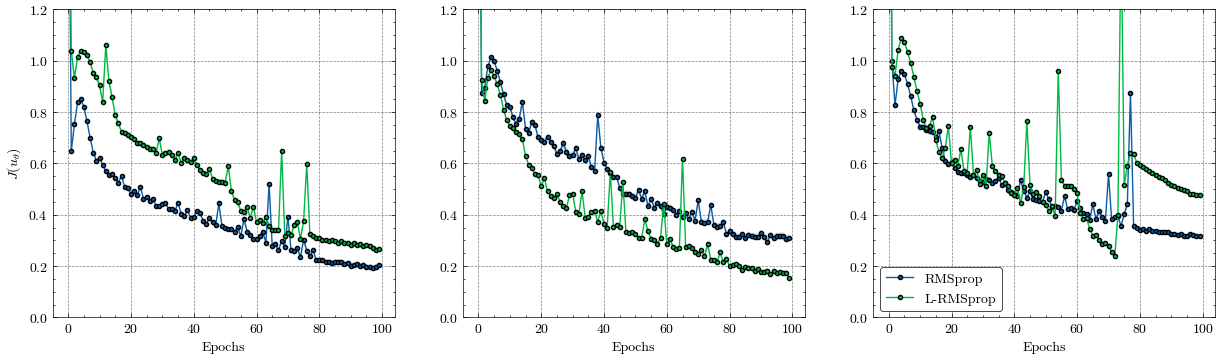

In [7]:
rmsprop_single_ctrl = test_diag_single_ctrl(
    model_config,
    [30, 50, 100],
    control_config,
    torch.optim.RMSprop,
    LRMSprop,
    "RMSprop",
    2e-3,
    2e-4,
    [2e-4, 2e-4, 2e-4],
    100,
    80,
)

Training Deep hedging with SGD:   0%|          | 0/100 [00:00<?, ?it/s]

Deep hedging: Epoch 99, SGD, lr=0.003, sigma=0.000, train=0.799, test=0.811: 100%|██████████| 100/100 [00:29<00:00,  3.40it/s]
Deep hedging: Epoch 99, L-SGD, lr=0.003, sigma=0.000, train=0.588, test=0.595: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
Deep hedging: Epoch 99, SGD, lr=0.003, sigma=0.000, train=0.309, test=0.296: 100%|██████████| 100/100 [00:49<00:00,  2.04it/s]
Deep hedging: Epoch 99, L-SGD, lr=0.003, sigma=0.000, train=0.533, test=0.507: 100%|██████████| 100/100 [00:49<00:00,  2.02it/s]
Deep hedging: Epoch 99, SGD, lr=0.003, sigma=0.000, train=0.575, test=0.575: 100%|██████████| 100/100 [01:40<00:00,  1.00s/it]
Deep hedging: Epoch 99, L-SGD, lr=0.003, sigma=0.000, train=nan, test=nan: 100%|██████████| 100/100 [01:40<00:00,  1.01s/it]   


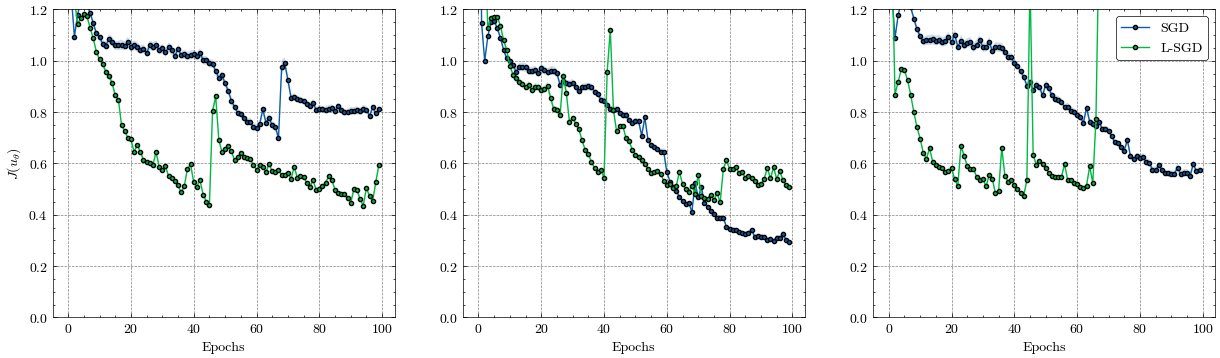

In [12]:
sgd_single_ctrl = test_diag_single_ctrl(
    model_config,
    [30, 50, 100],
    control_config,
    torch.optim.SGD,
    APLSGD,
    "SGD",
    3e-2,
    3e-3,
    [5e-4, 5e-4, 5e-4],
    100,
    80,
    momentum=0.9,
)

In [13]:
adam_single_ctrl.savefig("graphs/deephedging/adam_single_ctrl.pdf")
adadelta_single_ctrl.savefig("graphs/deephedging/adadelta_single_ctrl.pdf")
rmsprop_single_ctrl.savefig("graphs/deephedging/rmsprop_single_ctrl.pdf")
sgd_single_ctrl.savefig("graphs/deephedging/sgd_single_ctrl.pdf")

### Multiple controls:

In [19]:
model_config = dict(
    T=1.0,
    N_euler=10,
    dim=dim,
    ell=ell,
    a=torch.ones(dim),
    b=0.04 * torch.ones(dim),
    sigma=2.0 * torch.ones(dim),
    rho=-0.7 * torch.ones(dim),
    K=s0 * torch.ones(dim),
    T_COST=5e-4,
    S_0=s0 * torch.ones(dim),
    V_0=v0 * torch.ones(dim),
)

control_config = dict(
    input_dim=4 * dim,
    output_dim=2 * dim,
    hidden_dim=32,
    depth=2,
    activation=nn.ReLU(),
    out_transform=nn.ReLU(),
)

epochs = 200

In [20]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=True)
optim_w = optim.SGD(ocp.w.parameters(), lr=2e-3, momentum=0.9)
adam_control = [optim.Adam(control.parameters(), lr=2e-3) for control in ocp.control]
adam = [optim_w, *adam_control]

scheduler_w = PiecewiseConstantScheduler(
    optim_w, target_lr=2e-4, target_sigma=0, total_iters=80
)
scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=180)
    for opt in adam_control
]
scheduler = [scheduler_w, *scheduler_control]

In [21]:
train_loss_adam, test_loss_adam, test_ci_adam = train(
    ocp,
    adam,
    scheduler,
    "Adam",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 199, Adam, lr=0.000, sigma=[0], train=0.664, test=0.673: 100%|██████████| 200/200 [00:24<00:00,  8.31it/s]


In [22]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=True)
optim_w = optim.SGD(ocp.w.parameters(), lr=2e-3, momentum=0.9)
ladam_control = [
    LAdam(control.parameters(), lr=2e-3, sigma=2e-4) for control in ocp.control
]
ladam = [optim_w, *ladam_control]

scheduler_w = PiecewiseConstantScheduler(
    optim_w, target_lr=2e-4, target_sigma=0, total_iters=180
)
scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=180)
    for opt in ladam_control
]
scheduler = [scheduler_w, *scheduler_control]

In [23]:
train_loss_ladam, test_loss_ladam, test_ci_ladam = train(
    ocp,
    ladam,
    scheduler,
    "LAdam",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Training Deep hedging with LAdam:   0%|          | 0/200 [00:00<?, ?it/s]

Deep hedging: Epoch 199, LAdam, lr=0.000, sigma=[0], train=0.419, test=0.390: 100%|██████████| 200/200 [00:24<00:00,  8.03it/s]     


In [24]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=True)
optim_w = optim.SGD(ocp.w.parameters(), lr=2e-3, momentum=0.9)
ll = 30
lladam_control = []
for i, control in enumerate(ocp.control):
    if 100 * i / len(ocp.control) <= ll:
        lladam_control.append(LAdam(control.parameters(), lr=2e-3, sigma=2e-4))
    else:
        lladam_control.append(optim.Adam(control.parameters(), lr=2e-3))

lladam = [optim_w, *lladam_control]

scheduler_w = PiecewiseConstantScheduler(
    optim_w, target_lr=2e-4, target_sigma=0, total_iters=180
)
scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=180)
    for opt in lladam_control
]
scheduler = [scheduler_w, *scheduler_control]

In [25]:
train_loss_ll30_adam, test_loss_ll30_adam, test_ci_ll30_adam = train(
    ocp,
    lladam,
    scheduler,
    "LLAdam",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 199, LLAdam, lr=0.000, sigma=[0], train=0.415, test=0.435: 100%|██████████| 200/200 [00:24<00:00,  8.22it/s]


In [26]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=True)
optim_w = optim.SGD(ocp.w.parameters(), lr=2e-3, momentum=0.9)
ll = 90
lladam_control = []
for i, control in enumerate(ocp.control):
    if 100 * i / len(ocp.control) <= ll:
        lladam_control.append(LAdam(control.parameters(), lr=2e-3, sigma=2e-4))
    else:
        lladam_control.append(optim.Adam(control.parameters(), lr=2e-3))

lladam = [optim_w, *lladam_control]

scheduler_w = PiecewiseConstantScheduler(
    optim_w, target_lr=2e-4, target_sigma=0, total_iters=180
)
scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=180)
    for opt in lladam_control
]
scheduler = [scheduler_w, *scheduler_control]

In [27]:
train_loss_ll90_adam, test_loss_ll90_adam, test_ci_ll90_adam = train(
    ocp,
    lladam,
    scheduler,
    "LLAdam",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 199, LLAdam, lr=0.000, sigma=[0], train=0.281, test=0.265: 100%|██████████| 200/200 [00:24<00:00,  8.12it/s]     


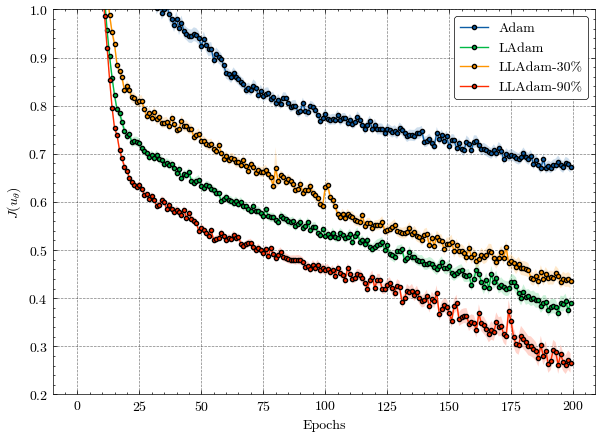

In [28]:
plot_langevin_loss(
    test_loss_adam,
    test_ci_adam,
    test_loss_ladam,
    test_ci_ladam,
    test_loss_llangevin=[test_loss_ll30_adam, test_loss_ll90_adam],
    test_ci_llangevin=[test_ci_ll30_adam, test_ci_ll90_adam],
    ll=[30, 90],
    name="Adam",
    ylim=(0.2, 1.0),
)

In [29]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=True)
optim_w = optim.SGD(ocp.w.parameters(), lr=2e-3, momentum=0.9)
adadelta_control = [
    optim.Adadelta(control.parameters(), lr=5e-1, rho=0.95) for control in ocp.control
]
adadelta = [optim_w, *adadelta_control]

scheduler_w = PiecewiseConstantScheduler(
    optim_w, target_lr=5e-2, target_sigma=0, total_iters=180
)
scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=5e-2, target_sigma=0, total_iters=180)
    for opt in adadelta_control
]
scheduler = [scheduler_w, *scheduler_control]

In [30]:
train_loss_adadelta, test_loss_adadelta, test_ci_adadelta = train(
    ocp,
    adadelta,
    scheduler,
    "Adadelta",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 199, Adadelta, lr=0.050, sigma=[0], train=0.741, test=0.731: 100%|██████████| 200/200 [00:23<00:00,  8.58it/s]


In [31]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=True)
optim_w = optim.SGD(ocp.w.parameters(), lr=2e-3, momentum=0.9)
ladadelta_control = [
    LAdadelta(control.parameters(), lr=5e-1, sigma=5e-3) for control in ocp.control
]
ladadelta = [optim_w, *ladadelta_control]

scheduler_w = PiecewiseConstantScheduler(
    optim_w, target_lr=5e-2, target_sigma=0, total_iters=180
)
scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=5e-2, target_sigma=0, total_iters=180)
    for opt in ladadelta_control
]
scheduler = [scheduler_w, *scheduler_control]

In [32]:
train_loss_ladadelta, test_loss_ladadelta, test_ci_ladadelta = train(
    ocp,
    ladadelta,
    scheduler,
    "LAdadelta",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 199, LAdadelta, lr=0.050, sigma=[0], train=0.281, test=0.214: 100%|██████████| 200/200 [00:21<00:00,  9.51it/s]    


In [33]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=True)
optim_w = optim.SGD(ocp.w.parameters(), lr=2e-3, momentum=0.9)
ll = 30
lladadelta_control = []
for i, control in enumerate(ocp.control):
    if 100 * i / len(ocp.control) <= ll:
        lladadelta_control.append(LAdadelta(control.parameters(), lr=5e-1, sigma=5e-3))
    else:
        lladadelta_control.append(
            optim.Adadelta(control.parameters(), lr=5e-1, rho=0.95)
        )

lladadelta = [optim_w, *lladadelta_control]

scheduler_w = PiecewiseConstantScheduler(
    optim_w, target_lr=5e-2, target_sigma=0, total_iters=180
)
scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=5e-2, target_sigma=0, total_iters=180)
    for opt in lladadelta_control
]
scheduler = [scheduler_w, *scheduler_control]

In [34]:
train_loss_ll30_adadelta, test_loss_ll30_adadelta, test_ci_ll30_adadelta = train(
    ocp,
    lladadelta,
    scheduler,
    "LLAdadelta",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 199, LLAdadelta, lr=0.050, sigma=[0], train=0.550, test=0.545: 100%|██████████| 200/200 [00:19<00:00, 10.07it/s]


In [35]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=True)
optim_w = optim.SGD(ocp.w.parameters(), lr=2e-3, momentum=0.9)
ll = 90
lladadelta_control = []
for i, control in enumerate(ocp.control):
    if 100 * i / len(ocp.control) <= ll:
        lladadelta_control.append(LAdadelta(control.parameters(), lr=5e-1, sigma=5e-3))
    else:
        lladadelta_control.append(
            optim.Adadelta(control.parameters(), lr=5e-1, rho=0.95)
        )

lladadelta = [optim_w, *lladadelta_control]

scheduler_w = PiecewiseConstantScheduler(
    optim_w, target_lr=5e-2, target_sigma=0, total_iters=180
)
scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=5e-2, target_sigma=0, total_iters=180)
    for opt in lladadelta_control
]
scheduler = [scheduler_w, *scheduler_control]

In [36]:
train_loss_ll90_adadelta, test_loss_ll90_adadelta, test_ci_ll90_adadelta = train(
    ocp,
    lladadelta,
    scheduler,
    "LLAdadelta",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 199, LLAdadelta, lr=0.050, sigma=[0], train=0.397, test=0.426: 100%|██████████| 200/200 [00:20<00:00,  9.75it/s]    


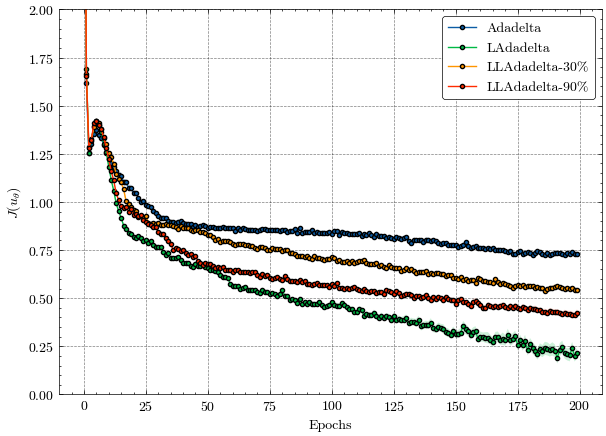

In [37]:
plot_langevin_loss(
    test_loss_adadelta,
    test_ci_adadelta,
    test_loss_ladadelta,
    test_ci_ladadelta,
    test_loss_llangevin=[test_loss_ll30_adadelta, test_loss_ll90_adadelta],
    test_ci_llangevin=[test_ci_ll30_adadelta, test_ci_ll90_adadelta],
    ll=[30, 90],
    name="Adadelta",
    ylim=(0, 2),
)

In [38]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=True)
optim_w = optim.SGD(ocp.w.parameters(), lr=2e-3, momentum=0.9)
rmsprop_control = [
    optim.RMSprop(control.parameters(), lr=2e-3) for control in ocp.control
]
rmsprop = [optim_w, *rmsprop_control]

scheduler_w = PiecewiseConstantScheduler(
    optim_w, target_lr=2e-4, target_sigma=0, total_iters=180
)
scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=180)
    for opt in rmsprop_control
]
scheduler = [scheduler_w, *scheduler_control]

In [39]:
train_loss_rmsprop, test_loss_rmsprop, test_ci_rmsprop = train(
    ocp,
    rmsprop,
    scheduler,
    "RMSprop",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 199, RMSprop, lr=0.000, sigma=[0], train=0.443, test=0.428: 100%|██████████| 200/200 [00:19<00:00, 10.43it/s]


In [40]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=True)
optim_w = optim.SGD(ocp.w.parameters(), lr=2e-3, momentum=0.9)
lrmsprop_control = [
    LRMSprop(control.parameters(), lr=2e-3, sigma=2e-3) for control in ocp.control
]
lrmsprop = [optim_w, *lrmsprop_control]

scheduler_w = PiecewiseConstantScheduler(
    optim_w, target_lr=2e-4, target_sigma=0, total_iters=180
)
scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=180)
    for opt in lrmsprop_control
]
scheduler = [scheduler_w, *scheduler_control]

In [41]:
train_loss_lrmsprop, test_loss_lrmsprop, test_ci_lrmsprop = train(
    ocp,
    lrmsprop,
    scheduler,
    "LRMSprop",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 199, LRMSprop, lr=0.000, sigma=[0], train=0.412, test=0.436: 100%|██████████| 200/200 [00:20<00:00,  9.99it/s]    


In [42]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=True)
optim_w = optim.SGD(ocp.w.parameters(), lr=2e-3, momentum=0.9)
ll = 30
llrmsprop_control = []
for i, control in enumerate(ocp.control):
    if 100 * i / len(ocp.control) <= ll:
        llrmsprop_control.append(LRMSprop(control.parameters(), lr=2e-3, sigma=2e-3))
    else:
        llrmsprop_control.append(optim.RMSprop(control.parameters(), lr=2e-3))

llrmsprop = [optim_w, *llrmsprop_control]

scheduler_w = PiecewiseConstantScheduler(
    optim_w, target_lr=2e-4, target_sigma=0, total_iters=180
)
scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=180)
    for opt in llrmsprop_control
]
scheduler = [scheduler_w, *scheduler_control]

In [43]:
train_loss_ll30_rmsprop, test_loss_ll30_rmsprop, test_ci_ll30_rmsprop = train(
    ocp,
    llrmsprop,
    scheduler,
    "LLRMSprop",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 199, LLRMSprop, lr=0.000, sigma=[0], train=0.398, test=0.392: 100%|██████████| 200/200 [00:19<00:00, 10.31it/s]


In [44]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=True)
optim_w = optim.SGD(ocp.w.parameters(), lr=2e-3, momentum=0.9)
ll = 90
llrmsprop_control = []
for i, control in enumerate(ocp.control):
    if 100 * i / len(ocp.control) <= ll:
        llrmsprop_control.append(LRMSprop(control.parameters(), lr=2e-3, sigma=2e-3))
    else:
        llrmsprop_control.append(optim.RMSprop(control.parameters(), lr=2e-3))

llrmsprop = [optim_w, *llrmsprop_control]

scheduler_w = PiecewiseConstantScheduler(
    optim_w, target_lr=2e-4, target_sigma=0, total_iters=180
)
scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=180)
    for opt in llrmsprop_control
]
scheduler = [scheduler_w, *scheduler_control]

In [45]:
train_loss_ll90_rmsprop, test_loss_ll90_rmsprop, test_ci_ll90_rmsprop = train(
    ocp,
    llrmsprop,
    scheduler,
    "LLRMSprop",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 199, LLRMSprop, lr=0.000, sigma=[0], train=0.359, test=0.358: 100%|██████████| 200/200 [00:20<00:00,  9.97it/s]    


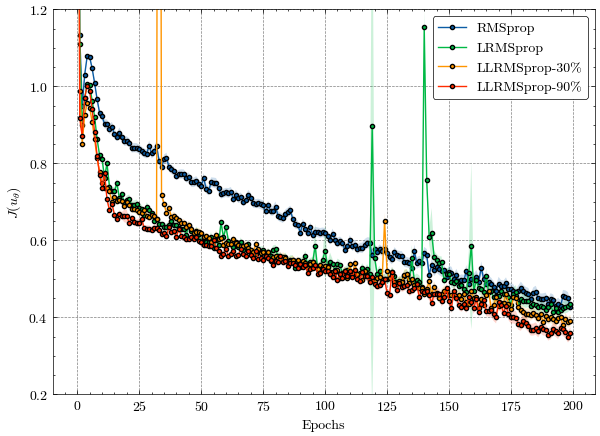

In [53]:
plot_langevin_loss(
    test_loss_rmsprop,
    test_ci_rmsprop,
    test_loss_lrmsprop,
    test_ci_lrmsprop,
    test_loss_llangevin=[test_loss_ll30_rmsprop, test_loss_ll90_rmsprop],
    test_ci_llangevin=[test_ci_ll30_rmsprop, test_ci_ll90_rmsprop],
    ll=[30, 90],
    name="RMSprop",
    ylim=(0.2, 1.2),
)

### Sample trajectory:

In [47]:
alpha = 0.9
ell = lambda x: nn.functional.relu(x) / (1.0 - alpha)
dim = 1
s0 = 1.0
v0 = 0.1


model_config = dict(
    T=1.0,
    N_euler=50,
    dim=dim,
    ell=ell,
    a=torch.ones(dim),
    b=0.04 * torch.ones(dim),
    sigma=2.0 * torch.ones(dim),
    rho=-0.7 * torch.ones(dim),
    K=s0 * torch.ones(dim),
    T_COST=5e-4,
    S_0=s0 * torch.ones(dim),
    V_0=v0 * torch.ones(dim),
)

control_config = dict(
    input_dim=1 + 4 * dim,
    output_dim=2 * dim,
    hidden_dim=32,
    depth=2,
    activation=nn.ReLU(),
    out_transform=nn.ReLU(),
)

In [48]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=False)
optim_w = optim.SGD(ocp.w.parameters(), lr=2e-3, momentum=0.9)
adam_control = optim.Adam(ocp.control.parameters(), lr=2e-3)
adam = [optim_w, adam_control]

scheduler_w = PiecewiseConstantScheduler(
    optim_w, target_lr=2e-4, target_sigma=0, total_iters=80
)
scheduler_control = PiecewiseConstantScheduler(
    adam_control, target_lr=2e-4, target_sigma=0, total_iters=80
)
scheduler = [scheduler_w, scheduler_control]

In [49]:
train_loss_adam, test_loss_adam, test_ci_adam = train(
    ocp,
    adam,
    scheduler,
    "Adam",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 199, Adam, lr=0.000, sigma=[0], train=0.079, test=0.079: 100%|██████████| 200/200 [00:45<00:00,  4.39it/s]


In [79]:
S1, S2, V, u = ocp.sample_traj(1)

Sampling trajectories: 100%|██████████| 50/50 [00:00<00:00, 6203.49it/s]


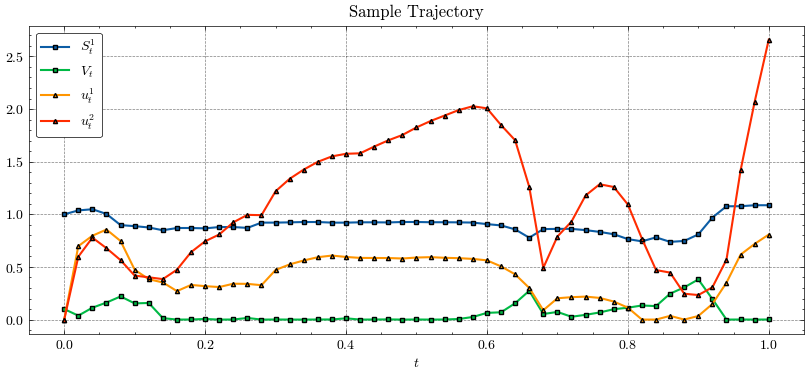

In [91]:
fig = plt.figure(figsize=(10, 4))

t = model_config["T"] / model_config["N_euler"] * np.arange(model_config["N_euler"] + 1)
plt.plot(
    t,
    S1.flatten().detach().numpy(),
    label=r"$S_t^1$",
    marker="s",
    mec="k",
    ms=3,
    lw=1.5,
)
plt.plot(
    t, V.flatten().detach().numpy(), label=r"$V_t$", marker="s", mec="k", ms=3, lw=1.5
)
plt.plot(
    t,
    u[:, :, 0].flatten().detach().numpy(),
    label=r"$u_t^1$",
    marker="^",
    mec="k",
    ms=3,
    lw=1.5,
)
plt.plot(
    t,
    u[:, :, 1].flatten().detach().numpy(),
    label=r"$u_t^2$",
    marker="^",
    mec="k",
    ms=3,
    lw=1.5,
)

legend = plt.legend(fancybox=True, edgecolor="black", loc=0)
legend.get_frame().set_linewidth(0.5)
plt.title("Sample Trajectory")
plt.xlabel(r"$t$")
# fig.savefig("graphs/deephedging/Sample_traj_hedging_N50.pdf")
plt.show()
plt.close()